In [1]:
import h5py
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
import scipy
import time

from os import listdir
from os.path import isfile, join

import matplotlib
from matplotlib import pyplot as plt

import bacco
import bacco.probabilistic_bias as pb

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../code')
import utils
import plotter

2024-08-19 00:56:02.491347: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-19 00:56:02.786314: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-19 00:56:02.788418: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 00:56:06.369332: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-19 00:56:11.973115: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

In [2]:
matplotlib.pyplot.style.use('default')
matplotlib.pyplot.close('all')

matplotlib.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams['xtick.labelsize'] = 16 
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 20
matplotlib.rcParams['lines.linewidth'] = 2

In [14]:
## TODO figure out which to be using!! 

## "NEW COSMOLOGY"
box_size = 480.279
omega_matter = 0.315
baryon_fraction = 0.155
omega_baryon = omega_matter * baryon_fraction
omega_cdm = omega_matter - omega_baryon
mill_planck_dict = {'omega_baryon': omega_baryon, #omega_m * baryon_fraction
             'omega_de': 0.685,
             'hubble': 0.673,
             'omega_cdm': omega_cdm,
             }
cosmo = bacco.Cosmology(verbose=False, **mill_planck_dict)

## ORIGINAL MILLENNIUM
#box_size = 500.
#cosmo = bacco.Cosmology(verbose=False, **bacco.cosmo_parameters.Millennium)

print(cosmo.pars)
h = cosmo.pars['hubble']

{'hubble': 0.673, 'sigma8': 0.9, 'A_s': None, 'omega_baryon': 0.048825, 'omega_cdm': 0.266175, 'w0': -1, 'wa': 0, 'ns': 0.9611, 'tau': 0.0952, 'approx_nu': False, 'num_massive_neutrinos': 0, 'neutrino_mass': 0.0, 'Neffective': 3.046, 'DeltaNeff': 3.046, 'GammaNu': 0.71611, 'omega_neutrino': 0.0, 'omega_matter': 0.315, 'omega_cold': 0.315, 'photon_temperature': 2.7255, 'omega_photons': 0.0, 'omega_rad': 0.0, 'omega_k': 0.0, 'omega_de': 0.685, 'omega_tot': 1.0}


In [40]:
gal_trees_arr = []
fn_trees_arr = []

dir_base = '/dipc/kstoreyf/external/LGalaxies2020_PublicRepository'
dir_base_input = '/dipc/kstoreyf/external/LGalaxaies2020_PublicRepository/input'
model = 'default' #'default'
if model=='default':
    test_str = 'test3'
elif model=='modified':
    test_str = 'test1'

tag_lgal = '_DM_fasttesting_treeloop'
tag_trees = '_tree0-511'
       
dir_out = f'{dir_base}/output/output{tag_lgal}/samples'
fn_out = f'{dir_out}/Planck_Mil-I_snapshots_{model}_{test_str}_z0.00-0.00_All{tag_trees}.npy'
print(fn_out)
gals = np.load(fn_out)
#gal_trees_arr.append(gals)
#fn_trees_arr.append(fn_out)

/dipc/kstoreyf/external/LGalaxies2020_PublicRepository/output/output_DM_fasttesting_treeloop/samples/Planck_Mil-I_snapshots_default_test3_z0.00-0.00_All_tree0-511.npy


In [13]:
#list(gals.dtype.names)

In [50]:
len(gals)

5770421

In [53]:
# treefiles with no gals! go back and deal with (rel. to mem errors? think so...)
treefiles_nogals = np.setdiff1d(np.arange(0, 512), list(set(gals['TreeFile'])))
print(treefiles_nogals)

[104 108 112 140 162 166 248 388 436 437 448 497 501]


In [62]:
powers_of_two = 2**np.arange(0, 10)
tree_groups = [list(range(0,pt)) for pt in powers_of_two]
tree_groups = [[5]] + tree_groups # add in that ol' classic

In [61]:
powers_of_two

array([  1,   2,   4,   8,  16,  32,  64, 128, 256])

In [56]:
TreeFilesTot = 512

smf_arr = []
for tree_group in tree_groups:
    print(f"TreeGroup: {tree_group[0]}-{tree_group[-1]}")
    i_group = np.isin(gals['TreeFile'], tree_group)
    log_mstar = np.log10(gals[i_group]['StellarMass'])
    
    n_trees = len(tree_group)
    vol_Mpc_thisfile = (box_size/h)**3 * n_trees / TreeFilesTot
    
    bins_log_mstar, smf = utils.compute_smf(log_mstar, vol_Mpc_thisfile)
    smf_arr.append(smf)

TreeGroup: 5-5
TreeGroup: 0-0
TreeGroup: 0-1
TreeGroup: 0-3
TreeGroup: 0-7
TreeGroup: 0-15
TreeGroup: 0-31
TreeGroup: 0-63
TreeGroup: 0-127
TreeGroup: 0-255


In [64]:
# just for now, delete later! missed full one
i_group = np.isin(gals['TreeFile'], tree_groups[-1])
log_mstar = np.log10(gals[i_group]['StellarMass'])

n_trees = len(tree_groups[-1])
vol_Mpc_thisfile = (box_size/h)**3 * n_trees / TreeFilesTot

bins_log_mstar, smf = utils.compute_smf(log_mstar, vol_Mpc_thisfile)
smf_arr.append(smf)

In [57]:
# probabilistic SMF
# in Mpc^-3 (no h factor!!)
fn_psmf_bgs = '../data/psmf.sv3.bgs_bright.z0.01_0.05.dat'
ms, psmf_bgs_mean, psmf_bgs_std = np.loadtxt(fn_psmf_bgs, unpack=True)

Trees 5-5
Trees 0-0
Trees 0-1
Trees 0-3
Trees 0-7
Trees 0-15
Trees 0-31
Trees 0-63
Trees 0-127
Trees 0-255
Trees 0-511


/tmp/ipykernel_309253/1822369275.py:32: RuntimeWarning: invalid value encountered in divide
  ax1.plot(bins_log_mstar, (smf_arr[i]-smf_fid)/smf_fid, lw=2, color=colors[i],


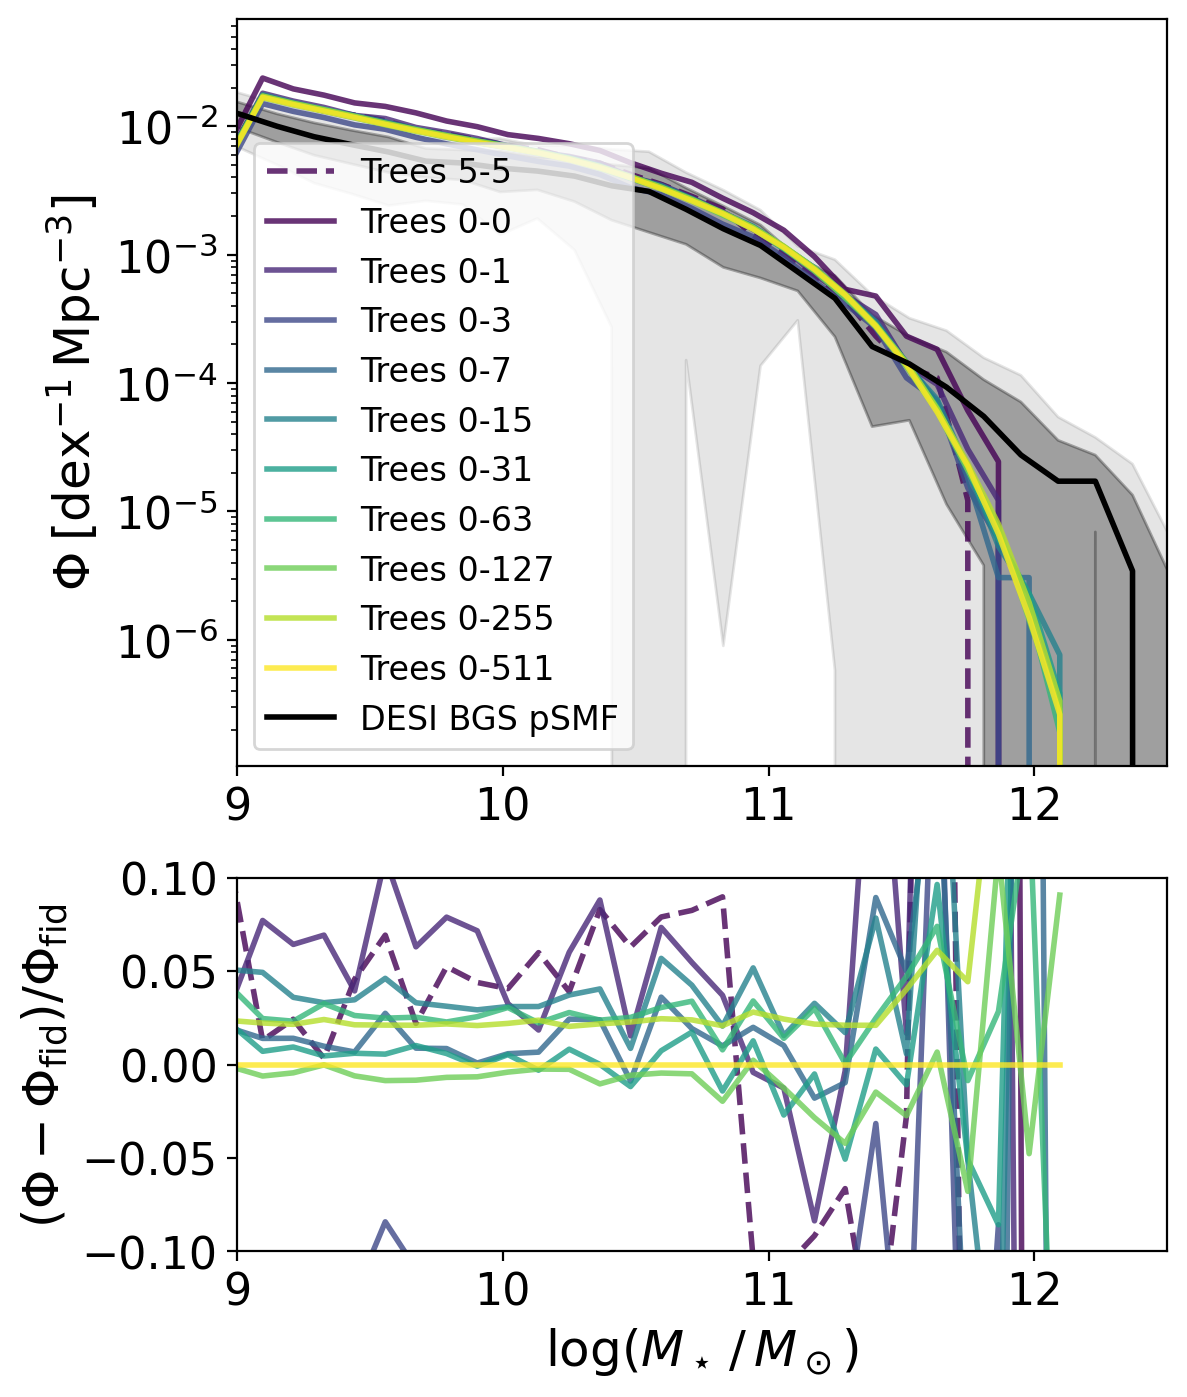

In [65]:
rng = np.random.default_rng()
#colors = ['black']*len(smf_arr)
#color_mode = 'continuous'
n_trees = [len(tree_group) for tree_group in tree_groups]
colors, cmap, locs_norm = utils.get_colors(n_trees, log=True)
#colors = ['green', 'blue', 'purple']
#lss = ['-', '--', '-.', ':', '-', '--', '-.', ':']
lss = ['--']+['-']*(len(smf_arr)-1)
color_mode = None

 
fig, axarr = plt.subplots(2, 1, figsize=(6, 8), #sharex=True, 
                          height_ratios=[2, 1])
ax, ax1 = axarr
 
i_fid = -1
smf_fid = smf_arr[i_fid]

for i in range(len(smf_arr)):
    # if i==0:
    #     label='L-Galaxies SMF'
    # else:
    #     label=None
    #label = tags_lgal[i][1:]
    label = f'Trees {tree_groups[i][0]}-{tree_groups[i][-1]}'
    ax.plot(bins_log_mstar, smf_arr[i], lw=2, color=colors[i], 
             ls=lss[i],
             alpha=0.8, label=label)
    
    print(label)
    #print((smf_arr[i]-smf_fid)/smf_fid)
    ax1.plot(bins_log_mstar, (smf_arr[i]-smf_fid)/smf_fid, lw=2, color=colors[i], 
            ls=lss[i],
            alpha=0.8, label=label)
    
if color_mode=='continuous':
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
    cb = plt.colorbar(sm, ax=ax, extend='max')
    cbar_label = r'$k_\text{AGN}$, efficiency of AGN feedback'
    cb.set_label(label=cbar_label, size=14)
        

ax.plot(ms, psmf_bgs_mean, color='black', label=r'DESI BGS pSMF')
ax.fill_between(ms, 
                 psmf_bgs_mean-psmf_bgs_std, 
                 psmf_bgs_mean+psmf_bgs_std,
                 color='black', alpha=0.3,
                 )
ax.fill_between(ms, 
                 psmf_bgs_mean-2*psmf_bgs_std, 
                 psmf_bgs_mean+2*psmf_bgs_std,
                 color='black', alpha=0.1,
                 )

# plt.errorbar(m13ksf_log_m_msun, m13ksf_phi_Mpcn3, yerr=m13ksf_err, color='blue', marker='o', 
#              alpha=0.5, markersize=4, ls='None', #facecolor='None', s=8,
#              label='SDSS/PRIMUS \n(Moustakas+2013)')
    
ax.set_xlim(9, 12.5)
ax1.set_xlim(9, 12.5)
#ax1.set_ylim(-0.25, 0.25)
ax1.set_ylim(-0.1, 0.1)

ax.set_yscale('log')
ax1.set_xlabel(r'$\log(M_\star\,/\,M_\odot)$')
ax.set_ylabel(r'$\Phi \: [\mathrm{dex}^{-1}\, \mathrm{Mpc}^{-3}]$')
ax1.set_ylabel(r'$(\Phi-\Phi_\text{fid})/\Phi_\text{fid}$')

handles, labels = ax.get_legend_handles_labels()
if color_mode=='discrete':
    handles.extend(handles_discrete)
ax.legend(handles=handles, fontsize=12)

